In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
#from sklearn.preprocessing import LabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#import imutils
import numpy as np
import os
import pandas as pd
from torch.utils.data import TensorDataset
import torch.nn as nn


# Veriye özel çok fazla IF koyduğum için bu yöntemle devam etmek istemedim.

In [2]:
def rotate_image(mat, angle):
    
    #Rotates an image (angle in degrees) and expands image to avoid cropping
    
    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(175,175,175))
    #rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h), borderMode=cv2.BORDER_REPLICATE)
    return rotated_mat

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#labels = ['A', 'B', 'C']
labels = [str(i) for i in range(10)]

y_true = np.array([[1, 0, 7],
                   [2, 3, 5],
                   [4, 5, 6]])
y_pred = np.array([[1, 0, 0],
                   [1, 3, 5],
                   [4, 5, 6]])

print(classification_report(y_true, y_pred, target_names=labels))

In [173]:
for i in os.listdir('Date Strings Part I/Part I/'):
    image = cv2.imread('Date Strings Part I/Part I/'+i)
    gray_ = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_ = gray_[10:-10, 3:-3]
    gray = rotate_image(gray_, 45)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    boundingBoxes = [cv2.boundingRect(c) for c in cnts[0]]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts[0], boundingBoxes), key=lambda b: b[1][0], reverse=False))
    
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 35 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            #padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
    #if len(chars) >= 5:
        #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-2][0].reshape(32,32), cmap='gray')
    #else:
    if (labels[i[:-4]][0] == 9 and labels[i[:-4]][1] < 2) or (labels[i[:-4]][0] == 8):

        if labels[i[:-4]][-1] == 0:
            plt.imsave('Date Strings Part I/0/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 1:
            plt.imsave('Date Strings Part I/1/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 2:
            plt.imsave('Date Strings Part I/2/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 3:
            plt.imsave('Date Strings Part I/3/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 4:
            plt.imsave('Date Strings Part I/4/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 5:
            plt.imsave('Date Strings Part I/5/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 6:
            plt.imsave('Date Strings Part I/6/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 7:
            plt.imsave('Date Strings Part I/7/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 8:
            plt.imsave('Date Strings Part I/8/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 9:
            plt.imsave('Date Strings Part I/9/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        
    #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')

In [174]:
for i in os.listdir('Date Strings Part II/Part II/'):
    image = cv2.imread('Date Strings Part II/Part II/'+i)
    gray_ = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_ = gray_[10:-10, 3:-3]
    gray = rotate_image(gray_, 45)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    boundingBoxes = [cv2.boundingRect(c) for c in cnts[0]]
    if len(boundingBoxes) == 0:
        print(i)
        continue
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts[0], boundingBoxes), key=lambda b: b[1][0], reverse=False))
    
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 35 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            #padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
    #if len(chars) >= 5:
        #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-2][0].reshape(32,32), cmap='gray')
    #else:
    if len(chars) == 0:
        print(i)
        continue

    if labels2[i[:-4]][-1] == 0:
        plt.imsave('Date Strings Part I/0/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 1:
        plt.imsave('Date Strings Part I/1/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 2:
        plt.imsave('Date Strings Part I/2/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 3:
        plt.imsave('Date Strings Part I/3/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 4:
        plt.imsave('Date Strings Part I/4/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 5:
        plt.imsave('Date Strings Part I/5/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 6:
        plt.imsave('Date Strings Part I/6/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 7:
        plt.imsave('Date Strings Part I/7/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 8:
        plt.imsave('Date Strings Part I/8/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels2[i[:-4]][-1] == 9:
        plt.imsave('Date Strings Part I/9/' + str(labels2[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        
    #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')

DateLocated_v166564.b67.s11.jpg
DateLocated_v166564.b106.s50.jpg
v166564.b115.s59.jpg
DateLocated_v166564.b109.s53.jpg
DateLocated_v166175.b18.s12.jpg
v166789.b43.s37.jpg
DateLocated_v168125.b173.s169.jpg
DateLocated_v166601.b45.s41.jpg
v166564.b91.s35.jpg
v166564.b95.s39.jpg
v166867.b69.s63.jpg
DateLocated_v166564.b218.s8.jpg
DateLocated_v166564.b254.s20.jpg
DateLocated_v30796.b7.jpg
v166564.b221.s11.jpg
v166564.b108.s52.jpg
DateLocated_v166564.b255.s21.jpg
DateLocated_v30738.b8.jpg
DateLocated_v166564.b257.s23.jpg
DateLocated_v30796.b13.jpg
DateLocated_v166564.b264.s30.jpg
DateLocated_v30360.b16.jpg
DateLocated_v166564.b253.s19.jpg
v166175.b19.s13.jpg
DateLocated_v166564.b222.s12.jpg
DateLocated_v168125.b334.s77.jpg


In [176]:
for i in os.listdir('Date Strings Part I/Part I/'):
    image = cv2.imread('Date Strings Part I/Part I/'+i)
    gray_ = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_ = gray_[10:-10, 3:-3]
    gray = rotate_image(gray_, 45)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    boundingBoxes = [cv2.boundingRect(c) for c in cnts[0]]
    if len(boundingBoxes) == 0:
        print(i)
        continue
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts[0], boundingBoxes), key=lambda b: b[1][0], reverse=False))
    
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 35 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            #padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
    #if len(chars) >= 5:
        #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-2][0].reshape(32,32), cmap='gray')
    #else:
    if len(chars) != 4:
        #print(i)
        continue
    if (labels[i[:-4]][0] == 9 and labels[i[:-4]][1] < 2) or (labels[i[:-4]][0] == 8):
        continue
    else:
        if labels[i[:-4]][-1] == 0:
            plt.imsave('Date Strings Part I/0/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 1:
            plt.imsave('Date Strings Part I/1/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 2:
            plt.imsave('Date Strings Part I/2/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 3:
            plt.imsave('Date Strings Part I/3/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 4:
            plt.imsave('Date Strings Part I/4/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 5:
            plt.imsave('Date Strings Part I/5/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 6:
            plt.imsave('Date Strings Part I/6/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 7:
            plt.imsave('Date Strings Part I/7/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 8:
            plt.imsave('Date Strings Part I/8/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        elif labels[i[:-4]][-1] == 9:
            plt.imsave('Date Strings Part I/9/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        
    #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')

In [210]:
for i in os.listdir('Date Strings Part I/Part I/'):
    if (labels[i[:-4]][0] == 9 and labels[i[:-4]][1] < 2) or (labels[i[:-4]][0] == 8):
        continue
    else:
        labels3.update({i[:-4]:labels[i[:-4]]})

In [211]:
len(labels3)

2076

In [177]:
for i in os.listdir('Date Strings Part III/Part III/'):
    image = cv2.imread('Date Strings Part III/Part III/'+i)
    gray_ = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_ = gray_[10:-10, 3:-3]
    gray = rotate_image(gray_, 45)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    boundingBoxes = [cv2.boundingRect(c) for c in cnts[0]]
    if len(boundingBoxes) == 0:
        print(i)
        continue
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts[0], boundingBoxes), key=lambda b: b[1][0], reverse=False))
    
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 35 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            #padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
    #if len(chars) >= 5:
        #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-2][0].reshape(32,32), cmap='gray')
    #else:
    if len(chars) == 0:
        print(i)
        continue

    if labels3[i[:-4]][-1] == 0:
        plt.imsave('Date Strings Part I/0/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 1:
        plt.imsave('Date Strings Part I/1/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 2:
        plt.imsave('Date Strings Part I/2/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 3:
        plt.imsave('Date Strings Part I/3/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 4:
        plt.imsave('Date Strings Part I/4/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 5:
        plt.imsave('Date Strings Part I/5/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 6:
        plt.imsave('Date Strings Part I/6/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 7:
        plt.imsave('Date Strings Part I/7/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 8:
        plt.imsave('Date Strings Part I/8/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
    elif labels3[i[:-4]][-1] == 9:
        plt.imsave('Date Strings Part I/9/' + str(labels3[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')
        
    #plt.imsave('Date Strings Part I/dataset/' + str(labels[i[:-4]][-1]) + i[:-4] + '.jpg', chars[-1][0].reshape(32,32), cmap='gray')

In [172]:
boundingBoxes

[]

In [451]:
type(chars[-1][0])

numpy.ndarray

In [456]:
Image.fromarray(chars[-1][0].reshape(32,32).astype('uint8')).show()

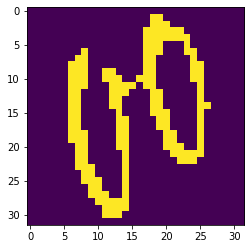

In [457]:
plt.imshow(chars[-1][0].astype('uint8'))

In [121]:
# Import the cv2 library
import cv2
# Read the image you want connected components of
src = cv2.imread('Date Strings Part I/Part I/T_v121027.b1120.s106.jpg')
gray_ = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
# Threshold it so it becomes binary
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
# You need to choose 4 or 8 for connectivity type
connectivity = 4
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

In [ ]:
plt.imshow(labels), centroids

In [8]:
image = cv2.imread('Date Strings Part I/Part I/T_v121553.b560.s46.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((1,1),np.uint8)
#print(gray[0][0])
gray = rotate_image(gray, 33)
#plt.imshow(gray, cmap='gray')
gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1)))
#gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
#gray = cv2.dilate(gray, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1)), iterations=10)
#gray = cv2.morphologyEx(gray, cv2.MORPH_ERODE, np.ones((1,1),np.uint8))

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#gray = cv2.filter2D(gray, -1, sharpen_kernel)

gray = cv2.GaussianBlur(gray, (3,3), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(gray, 30, 200)
#edged = cv2.morphologyEx(edged, cv2.MORPH_OPEN, np.ones((1,1), np.uint8))
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#a = tuple(np.asarray([cnts[0][i] for i in range(len(cnts[0])) if cnts[1][0][i][2] == -1]))
chars = []
boundingBoxes = [cv2.boundingRect(c) for c in cnts[0]]
(cnts, boundingBoxes) = zip(*sorted(zip(cnts[0], boundingBoxes), key=lambda b: b[1][0], reverse=False))


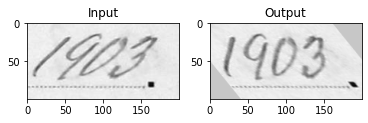

In [361]:
img = cv2.imread('Date Strings Part I/Part I/T_v120849.b2340.s227.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (200, 100))
rows,cols = img.shape

pts1 = np.float32([[50,1],[100,50],[200,1]])
pts2 = np.float32([[10,1],[100,50],[160,1]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(cols,rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(143,143,143))

plt.subplot(121),plt.imshow(img, cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
plt.show()

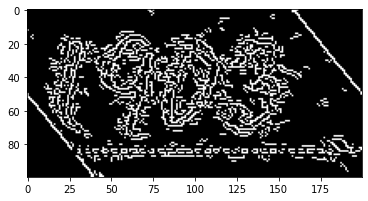

In [362]:
image = dst
original = image.copy()
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
dst = cv2.filter2D(dst, -1, sharpen_kernel)
canny = cv2.Canny(dst, 100, 200, 1)

kernel_45 = np.array([[1, -5, 0],
                      [-5,  5, -5],
                      [0, -5, 1]])


#canny = cv2.filter2D(canny, -1, kernel_45)
#kernel = np.ones((5, 5), np.uint8)
#dilated = cv2.dilate(dst, kernel, iterations = 1)
plt.imshow(canny, cmap='gray')

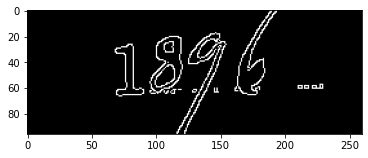

In [36]:
# HERE
import cv2
import numpy as np
from imutils import contours
from matplotlib import pyplot as plt

image = cv2.imread('Date Strings Part III/Part III/v121209.b130.s5.jpg')
#image = rotate_image(image, 33)
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#gray = cv2.filter2D(gray, -1, sharpen_kernel)
canny = cv2.Canny(gray, 130, 255, 1)

kernel_45 = np.array([[1, -5, 0],
                      [-5,  5, -5],
                      [0, -5, 1]])


#canny = cv2.filter2D(canny, -1, kernel_45)
#kernel = np.ones((5, 5), np.uint8)
#dilated = cv2.dilate(dst, kernel, iterations = 1)
plt.imshow(canny, cmap='gray')

In [37]:
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

digit_contours = []
for c in cnts:
    area = cv2.contourArea(c)
    #print(area)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    x,y,w,h = cv2.boundingRect(approx)
    aspect_ratio = w / float(h)

    #if (aspect_ratio >= 0.4 and aspect_ratio <= 1.3):
    if (w >= 5 and w <= 150) and (h >= 30 and h <= 300):
        ROI = original[y:y+h, x:x+w]
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        digit_contours.append(c)

sorted_digit_contours = contours.sort_contours(digit_contours, method='left-to-right')[0]
contour_number = 0
for c in sorted_digit_contours:
    x,y,w,h = cv2.boundingRect(c)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite('ROI_{}.png'.format(contour_number), ROI)
    contour_number += 1
len(sorted_digit_contours)

5

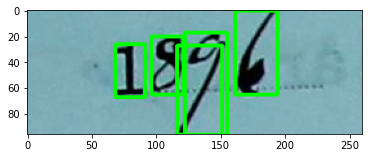

In [38]:
plt.imshow(image, cmap='gray')

In [302]:
plt.imshow(edged)

NameError: name 'edged' is not defined

In [10]:
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 45 and h <= 300):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		#padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		if np.histogram(padded, bins=32)[0][0] < 625 or np.histogram(padded, bins=32)[0][0] > 950:
			continue
		
		if np.sum(padded == 255) > 200:
			continue
		
		flag = False
		if len(chars) == 1:
			
			err = np.sum((padded.astype("float") - chars[-1][0].astype("float")) ** 2)
			err /= float(padded.shape[0] * padded.shape[1])
			if err < 2000:
				flag = True
				break
		if flag:
			continue
		
		#if len(chars) == 2:
  		#	plt.imshow(roi)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [11]:
len(cnts[0]), len(chars)

(76, 5)

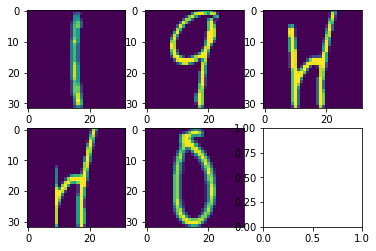

In [12]:
if len(chars) == 1:
    f, axarr = plt.subplots(1,1)
    axarr.imshow(chars[0][0])
elif len(chars) == 2:
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(chars[0][0])
    axarr[1].imshow(chars[1][0])
elif len(chars) == 3:
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[1,0].imshow(chars[2][0])
elif len(chars) == 4:
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[1,0].imshow(chars[2][0])
    axarr[1,1].imshow(chars[3][0])
elif len(chars) == 5:
    f, axarr = plt.subplots(2,3)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[0,2].imshow(chars[2][0])
    axarr[1,0].imshow(chars[3][0])
    axarr[1,1].imshow(chars[4][0])
elif len(chars) == 6:
    f, axarr = plt.subplots(2,3)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[0,2].imshow(chars[2][0])
    axarr[1,0].imshow(chars[3][0])
    axarr[1,1].imshow(chars[4][0])
    axarr[1,2].imshow(chars[5][0])
elif len(chars) == 7:
    f, axarr = plt.subplots(2,4)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[0,2].imshow(chars[2][0])
    axarr[0,3].imshow(chars[3][0])
    axarr[1,0].imshow(chars[4][0])
    axarr[1,1].imshow(chars[5][0])
    axarr[1,2].imshow(chars[6][0])
elif len(chars) == 8:
    f, axarr = plt.subplots(2,4)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[0,2].imshow(chars[2][0])
    axarr[0,3].imshow(chars[3][0])
    axarr[1,0].imshow(chars[4][0])
    axarr[1,1].imshow(chars[5][0])
    axarr[1,2].imshow(chars[6][0])
    axarr[1,3].imshow(chars[7][0])
elif len(chars) == 9:
    f, axarr = plt.subplots(2,5)
    axarr[0,0].imshow(chars[0][0])
    axarr[0,1].imshow(chars[1][0])
    axarr[0,2].imshow(chars[2][0])
    axarr[0,3].imshow(chars[3][0])
    axarr[0,4].imshow(chars[4][0])
    axarr[1,0].imshow(chars[5][0])
    axarr[1,1].imshow(chars[6][0])
    axarr[1,2].imshow(chars[7][0])
    axarr[1,3].imshow(chars[8][0])

In [ ]:
np.histogram(chars[1][0], bins=32)

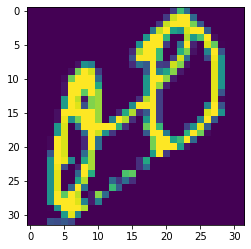

In [8]:
plt.imshow(chars[-1][0].astype('uint8'))

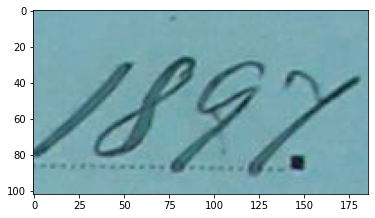

In [179]:
plt.imshow(image)

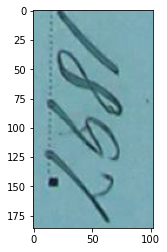

In [183]:
imager = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(imager)

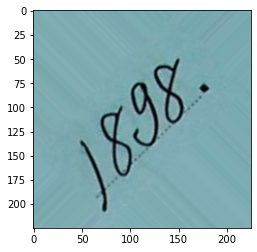

In [316]:
ro = rotate_image(image, 45)
plt.imshow(ro)

In [28]:
im = plt.imread('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')

In [12]:
im = Image.open('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')

In [23]:
im = Image.open('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')
im = np.array(im, dtype=np.float32)

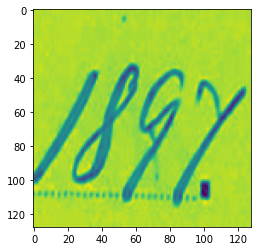

In [35]:
im = cv2.imread('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (128, 128))
plt.imshow(gray)

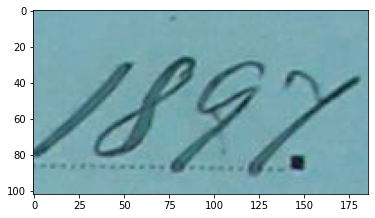

In [29]:
im = cv2.imread('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred)

In [24]:
im = Image.open('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')
im = np.array(im, dtype=np.float32)
im /= 255.0
im

array([[[0.7137255 , 0.6745098 , 0.4745098 ],
        [0.7176471 , 0.6784314 , 0.47843137],
        [0.72156864, 0.68235296, 0.48235294],
        ...,
        [0.7137255 , 0.6745098 , 0.48235294],
        [0.70980394, 0.67058825, 0.47843137],
        [0.70980394, 0.67058825, 0.47843137]],

       [[0.7176471 , 0.6784314 , 0.47843137],
        [0.7176471 , 0.6784314 , 0.47843137],
        [0.72156864, 0.68235296, 0.48235294],
        ...,
        [0.70980394, 0.67058825, 0.47843137],
        [0.70980394, 0.67058825, 0.47843137],
        [0.70980394, 0.67058825, 0.47843137]],

       [[0.72156864, 0.68235296, 0.48235294],
        [0.72156864, 0.68235296, 0.48235294],
        [0.7176471 , 0.6784314 , 0.47843137],
        ...,
        [0.70980394, 0.67058825, 0.47843137],
        [0.7058824 , 0.6666667 , 0.4745098 ],
        [0.70980394, 0.67058825, 0.47843137]],

       ...,

       [[0.7176471 , 0.6862745 , 0.49411765],
        [0.7176471 , 0.6862745 , 0.49411765],
        [0.7176471 , 0

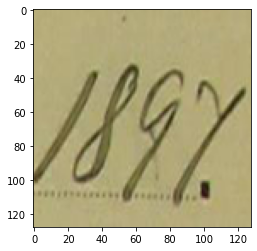

In [13]:
im = Image.open('Date Strings Part I/Part I/T_v120849.b70.s1.jpg')
im = np.array(im, dtype=np.float32)
im /= 255.0
im = im.resize((128, 128), Image.ANTIALIAS)
plt.imshow(im)

In [4]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#import imutils
import numpy as np
import os
import pandas as pd
from torch.utils.data import TensorDataset
import torch.nn as nn

In [2]:
picture_files = sorted(os.listdir('Date Strings Part I/Part I/'))

In [3]:
picture_files2 = sorted(os.listdir('Date Strings Part II/Part II/'))

In [4]:
picture_files3 = sorted(os.listdir('Date Strings Part III/Part III/'))

In [5]:
pictures = {}

In [6]:
pictures2 = {}

In [7]:
pictures3 = {}

In [8]:
for picture_file in picture_files:
    im = cv2.imread('Date Strings Part I/Part I/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures[picture_file[:-4]] = im

In [9]:
for picture_file in picture_files2:
    im = cv2.imread('Date Strings Part II/Part II/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures2[picture_file[:-4]] = im

In [10]:
for picture_file in picture_files3:
    im = cv2.imread('Date Strings Part III/Part III/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures3[picture_file[:-4]] = im

In [11]:
pictures_train = []
labels_train = []
pictures_test = []
labels_test = []

In [12]:
dfs = pd.read_excel('Date Strings Part I/Part I.xlsx')
dfs2 = pd.read_excel('Date Strings Part II/Part II.xlsx')
dfs3 = pd.read_excel('Date Strings Part III/Part III.xlsx')
labels = {}
labels2 = {}
labels3 = {}

In [13]:
for i in range(2548):
    if not pd.isnull(dfs.iloc[i,:].Image_Left):
        labels[dfs.iloc[i,:].Image_Left] = [int(j) for j in str(dfs.iloc[i,:].Date)[1:]]
    if not pd.isnull(dfs.iloc[i,:].Image_Right):
        labels[dfs.iloc[i,:].Image_Right] = [int(j) for j in str(dfs.iloc[i,:].Date)[1:]]

In [14]:
for i in range(3296):
    if not pd.isnull(dfs2.iloc[i,:].Image_Left):
        labels2[dfs2.iloc[i,:].Image_Left] = [int(j) for j in str(dfs2.iloc[i,:].Date)[1:]]
    if not pd.isnull(dfs2.iloc[i,:].Image_Right):
        labels2[dfs2.iloc[i,:].Image_Right] = [int(j) for j in str(dfs2.iloc[i,:].Date)[1:]]

In [15]:
for i in range(1520):
    labels3[dfs3.iloc[i,:].Image_name] = [int(j) for j in str(dfs3.iloc[i,:].Date)[1:]]

In [16]:
for picture_file in picture_files:
    if (labels[picture_file[:-4]][0] == 9 and labels[picture_file[:-4]][1] < 2) or (labels[picture_file[:-4]][0] == 8):
        pictures_train.append(pictures[picture_file[:-4]])
        labels_train.append(labels[picture_file[:-4]])
    else:
        pictures_test.append(pictures[picture_file[:-4]])
        labels_test.append(labels[picture_file[:-4]])

In [17]:
for picture_file in picture_files2:
    pictures_train.append(pictures2[picture_file[:-4]])
    labels_train.append(labels2[picture_file[:-4]])

In [18]:
for picture_file in picture_files3:
    pictures_test.append(pictures3[picture_file[:-4]])
    labels_test.append(labels3[picture_file[:-4]])

In [19]:
len(pictures_train), len(labels_train), len(pictures_test), len(labels_test)

(7924, 7924, 2076, 2076)

In [20]:
pictures_train = np.array(pictures_train)
labels_train = np.array(labels_train, dtype=np.float32)
pictures_test = np.array(pictures_test)
labels_test = np.array(labels_test, dtype=np.float32)

In [30]:
#train_dataset = torchvision.datasets.ImageFolder(root='Date Strings Part I', transform=transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()]))

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_x = torch.Tensor(pictures_train).type(torch.FloatTensor).to(device)
train_y = torch.Tensor(labels_train).type(torch.FloatTensor).to(device)
test_x = torch.Tensor(pictures_test).type(torch.FloatTensor).to(device)
test_y = torch.Tensor(labels_test).type(torch.FloatTensor).to(device)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64)

In [32]:
for i in range(len(train_dataset.imgs)):
    train_dataset.imgs[i] = (train_dataset.imgs[i][0], labels[train_dataset.imgs[i][0][27:-4]])

In [33]:
for i in range(len(train_dataset.imgs)):
    train_dataset.targets[i] = train_dataset.imgs[i][1]

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [35]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

In [36]:
train_list = []
for i in range(len(train_dataset.imgs)):
    train_list.append(plt.imread(train_dataset.imgs[i][0]))

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root='Date Strings Part I/dataset/train', 
                                                 transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))]))

In [262]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [203]:
test_dataset = torchvision.datasets.ImageFolder(root='Date Strings Part I/dataset/test',
                                                transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))]))

In [204]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
sample[0][:,0]

In [316]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(x.size(0), -1) 
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [46]:
class SequentialMultiLabeled(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        
        super(SequentialMultiLabeled, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.second = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
        self.third = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
        self.fourth = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
    
    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), 
                        self.hidden_size).to(device) 
        c = torch.zeros(self.num_layers, x.size(0), 
                        self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h, c))  
        
        #out = self.fc(out[:, -1, :])
        
        #out = torch.flatten(out[:, -1, :], 1)
        
        return {
            'second': self.second(out[:, -1, :]),
            'third': self.third(out[:, -1, :]),
            'fourth': self.fourth(out[:, -1, :])
        }

In [80]:
# Hyper parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 128
num_classes = 10
batch_size = 64
input_size = 128
num_layers = 2
num_epochs = 100
model = SequentialMultiLabeled(input_size, hidden_size, num_layers, num_classes).to(device)

In [81]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [82]:
def criterion(loss_func, outputs, labelList):
  losses = 0
  losses += loss_func(outputs['second'], labelList[:, 0])
  losses += loss_func(outputs['third'], labelList[:, 1])
  losses += loss_func(outputs['fourth'], labelList[:, 2])
  """
  for i, element in enumerate(outputs):
    for key in ['second', 'third', 'fourth']:
      if key == 'second':
        losses += loss_func(element[key], labelList[i][0])
      if key == 'third':
        losses += loss_func(element[key], labelList[i][1])
      if key == 'fourth':
        losses += loss_func(element[key], labelList[i][2])
  """
  return losses

In [84]:
def training(model, lr_rate, epochs, train_loader):
  num_epochs = epochs
  losses = []
  checkpoint_losses = []

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate)

  loss_func = nn.CrossEntropyLoss()
  
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.01, patience=5, verbose=True, factor=0.5)
  model.train()
  for epoch in range(num_epochs):
    for i, pictures in enumerate(train_loader):

     outputs = model(pictures[0])

     loss = criterion(loss_func, outputs, pictures[1].type(torch.LongTensor).to(device))
     losses.append(loss.item())

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

    checkpoint_loss = torch.tensor(losses[:-10]).mean().item()
    checkpoint_losses.append(checkpoint_loss)
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {checkpoint_loss:.4f}')
      
    #scheduler.step(checkpoint_loss)
        
  return checkpoint_losses

checkpoint_losses = training(model, 3e-3, 100, train_loader)

Epoch [1/100], Loss: 2.6683
Epoch [2/100], Loss: 2.6462
Epoch [3/100], Loss: 2.6293
Epoch [4/100], Loss: 2.6072
Epoch [5/100], Loss: 2.5888
Epoch [6/100], Loss: 2.5698
Epoch [7/100], Loss: 2.5529
Epoch [8/100], Loss: 2.5329
Epoch [9/100], Loss: 2.5150
Epoch [10/100], Loss: 2.4967
Epoch [11/100], Loss: 2.4782
Epoch [12/100], Loss: 2.4718
Epoch [13/100], Loss: 2.4605
Epoch [14/100], Loss: 2.4430
Epoch [15/100], Loss: 2.4281
Epoch [16/100], Loss: 2.4142
Epoch [17/100], Loss: 2.3963
Epoch [18/100], Loss: 2.3804
Epoch [19/100], Loss: 2.3667
Epoch [20/100], Loss: 2.3500
Epoch [21/100], Loss: 2.3329
Epoch [22/100], Loss: 2.3171
Epoch [23/100], Loss: 2.3049
Epoch [24/100], Loss: 2.2900
Epoch [25/100], Loss: 2.2759
Epoch [26/100], Loss: 2.2617
Epoch [27/100], Loss: 2.2467
Epoch [28/100], Loss: 2.2333
Epoch [29/100], Loss: 2.2203
Epoch [30/100], Loss: 2.2066
Epoch [31/100], Loss: 2.1945
Epoch [32/100], Loss: 2.1808
Epoch [33/100], Loss: 2.1674
Epoch [34/100], Loss: 2.1534
Epoch [35/100], Loss: 2

In [85]:
a = next(iter(train_loader))

In [86]:
a[1][34]

tensor([9., 1., 7.], device='cuda:0')

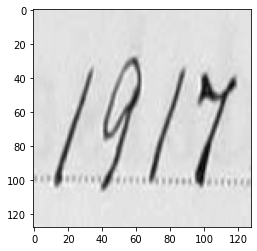

In [87]:
plt.imshow(a[0][34].cpu().detach().numpy(), cmap='gray')

In [88]:
b = model(a[0])

In [89]:
b['second'][34], b['third'][34], b['fourth'][34]

(tensor([-34.4956, -33.9227, -34.8741, -33.6441, -34.6283, -33.7098, -34.8364,
         -34.2728,  -5.4119,   6.5938], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([ -1.5754,   4.0502, -34.0821, -33.6034, -33.1322, -33.9859, -33.6909,
         -33.1389, -34.1720,  -5.0722], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([-6.0398, -8.3193, -1.4434,  1.9418, -3.9084, -0.8344, -6.6500,  4.2084,
         -0.9412,  2.5411], device='cuda:0', grad_fn=<SelectBackward0>))

In [134]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        correct_digits = 0
        total_digits = 0
        model.eval()

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                predicted_second = torch.argmax(outputs['second'], dim=1)
                predicted_third = torch.argmax(outputs['third'], dim=1)
                predicted_fourth = torch.argmax(outputs['fourth'], dim=1)
                total += labels[:, 0].type(torch.LongTensor).to(device).shape[0]
                total_digits += labels[:, 0].type(torch.LongTensor).to(device).shape[0]*3
                correct_second = (predicted_second == labels[:, 0])
                correct_third = (predicted_third == labels[:, 1])
                correct_fourth = (predicted_fourth == labels[:, 2])
                correct_digits += int(correct_second.sum()) + int(correct_third.sum()) + int(correct_fourth.sum())
                correct_second_third = (correct_second == correct_third)
                correct_second_third_fourth = (correct_second_third == correct_fourth)
                correct += int(correct_second_third_fourth.sum())

        print("Accuracy {}: {:.2f} : {:.2f}".format(name , correct / total, correct_digits / total_digits))

validate(model, train_loader, test_loader)

Accuracy train: 0.70 : 0.84
Accuracy val: 0.53 : 0.58


In [106]:
iter = iter(test_loader)

In [ ]:
a_ = next(iter)

In [ ]:
b_ = model(a_[0])

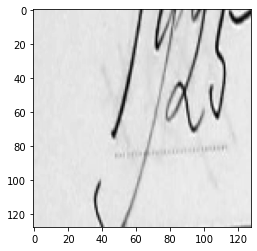

In [124]:
plt.imshow(a_[0][34].cpu().detach().numpy(), cmap='gray')

In [125]:
b_['second'][34], b_['third'][34], b_['fourth'][34]

(tensor([-27.4803, -27.3327, -27.5612, -27.2069, -27.4114, -27.1457, -27.5773,
         -27.3346,  -3.4024,   4.7606], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([ -0.0913,   2.6727, -26.6905, -26.7174, -26.3394, -26.7118, -26.5761,
         -26.4442, -26.7705,  -5.2817], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([-1.7657, -3.5077,  0.0686,  1.8118, -1.4224,  1.7567, -2.2276, -2.0280,
         -0.9769, -2.6397], device='cuda:0', grad_fn=<SelectBackward0>))

In [319]:
output = model(sample[0][:,0].unsqueeze(1).to(device))

In [320]:
output.shape

torch.Size([64, 10])

In [ ]:
num_epochs = 100
train_losses = []
train_counter = []

def train(epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    #print(data[:,0].unsqueeze(1).shape)
    output = model(data[:,0].unsqueeze(1).to(device))
    loss = loss_func(output, target.to(device))
    loss.backward()
    optimizer.step()
  
  print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())
  #torch.save(model.state_dict(), '/results/model.pth')
  #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

for epoch in range(1, num_epochs + 1):
  train(epoch)

In [158]:
model.eval()

SequentialMultiLabeled(
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (second): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (third): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (fourth): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
data

In [161]:
t = model.third

In [167]:
model.third = t

In [164]:
model(test_x[0].unsqueeze(0).to(device))

{'second': tensor([[ -9.2245, -10.0935,  -9.8823,  -9.6473,  -9.2980, -10.0466,  -9.6255,
           -9.8753,   0.6173,   3.1449]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 'third': tensor([[-0.2043,  0.2902,  0.3182,  0.3123, -0.4473,  0.2958,  0.2473, -0.7676,
          -0.2718, -1.6103]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'fourth': tensor([[-0.2043,  0.2902,  0.3182,  0.3123, -0.4473,  0.2958,  0.2473, -0.7676,
          -0.2718, -1.6103]], device='cuda:0', grad_fn=<AddmmBackward0>)}

In [159]:
model(test_x[0].unsqueeze(0).to(device))

{'second': tensor([[ -9.2245, -10.0935,  -9.8823,  -9.6473,  -9.2980, -10.0466,  -9.6255,
           -9.8753,   0.6173,   3.1449]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 'third': tensor([[  1.9653,   2.2615,  -9.9421,  -9.8003,  -9.8965, -10.1204, -10.1581,
          -10.1534,  -9.4693,   0.3265]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 'fourth': tensor([[-0.2043,  0.2902,  0.3182,  0.3123, -0.4473,  0.2958,  0.2473, -0.7676,
          -0.2718, -1.6103]], device='cuda:0', grad_fn=<AddmmBackward0>)}

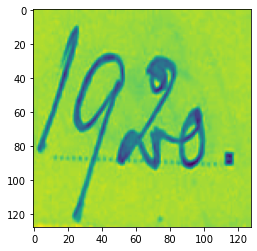

In [160]:
plt.imshow(test_x[0].cpu())

In [168]:
model(test_x[1].unsqueeze(0).to(device))

{'second': tensor([[-8.9730, -9.5020, -9.5070, -9.5045, -8.9842, -9.4791, -9.3827, -9.3893,
           1.3868,  1.0874]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'third': tensor([[ 0.3117,  1.2269, -8.8434, -8.8295, -9.2111, -9.1799, -9.4012, -9.3266,
          -8.6783,  1.8262]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'fourth': tensor([[-1.2173, -0.6069, -0.4692, -0.2677, -0.8676,  0.6579,  0.6044,  0.8923,
           0.3602, -0.1469]], device='cuda:0', grad_fn=<AddmmBackward0>)}

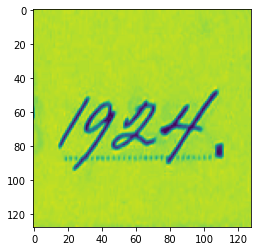

In [173]:
plt.imshow(test_x[15].cpu())